# AGH Modelling of Physical Systems Lab 6 (2025 April 8th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl) & Emma Ware (ecware@ucdavis.edu) 

**1. particle-resolved random-sampled state representation for an advection problem**

In [86]:
""" notebook code targetting 100% `nbqa pylint` score! :) """

from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot
import scipy
from open_atmos_jupyter_utils import show_plot

In [87]:
PARAMS_P = SimpleNamespace(
    n_part=1000,
    norm=1e10,
    dist=scipy.stats.norm(loc=250, scale=50), # gaussian norm
)

PARAMS_X = SimpleNamespace(
    span=1000,
    n_cell=50,
)
PARAMS_X.step = PARAMS_X.span / PARAMS_X.n_cell

RNG = np.random.default_rng(seed=42)

In [88]:
def sample(*, params_p, params_x, rng):
    """ samples a particle population specified onto a grid and returns
    a collection indexed by sampling type, with values composed of `cell` and `mult`
    integer-valued arrays with cell IDs and multiplicities, respectively """
    u01 = rng.uniform(0, 1, size=params_p.n_part)

    return {
        k: {
            'cell': (v['cell'] / params_x.step).astype(int),
            'mult': np.round(v['mult'] * params_p.norm).astype(int),
        }
        for k,v in
        {
            'sampling: uniform random in x': {
                'cell': u01 * params_x.span,
                'mult': params_p.dist.pdf(u01 * params_x.span) * params_x.span / params_p.n_part,
            },
            'sampling: constant multiplicity': {
                'cell': params_p.dist.ppf(u01),
                'mult': np.ones_like(u01) / params_p.n_part,
            }
        }.items()
    }

PARTICLES = sample(params_p=PARAMS_P, params_x=PARAMS_X, rng=RNG)

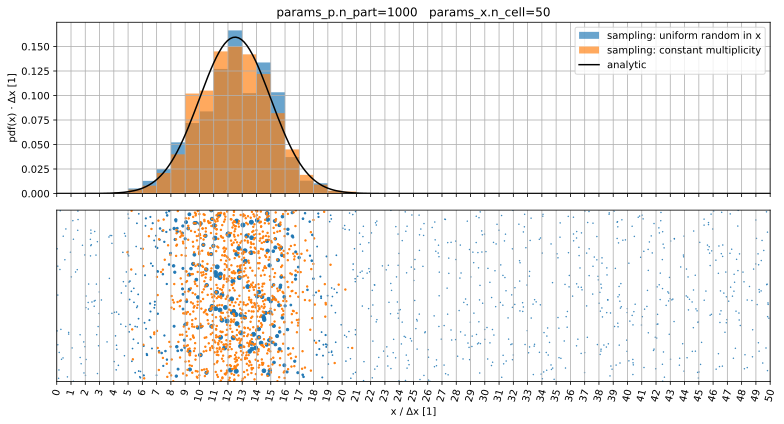

In [89]:
def plot(*, particles, params_p, params_x, rng, title='', shift=0):
    """ plots the particle state as both a histogram as well as population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    _, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(11, 6),
        sharex=True,
        tight_layout=True,
    )
    u01 = rng.uniform(0, 1, params_p.n_part)
    scale = params_p.norm / params_p.n_part
    for k in particles:
        axs['hist'].hist(
            x=particles[k]['cell'],
            weights=particles[k]['mult'] / params_p.norm,
            bins=params_x.n_cell,
            range=(0, params_x.n_cell),
            label=f'{k}',
            alpha=.666
        )
        axs['part'].scatter(
            particles[k]['cell'] + u01,
            tuple(reversed(u01)),
            s=.25 + 2 * particles[k]['mult'] / scale
        )
    pdf_x = np.linspace(0, params_x.span, 256)
    pdf_y = params_p.dist.pdf(pdf_x - shift)
    axs['hist'].plot(pdf_x / params_x.step, pdf_y * params_x.step, color='black', label='analytic')
    axs['hist'].set_xlim(0, params_x.n_cell)
    axs['hist'].legend()
    axs['hist'].set_ylabel('pdf(x) ⋅ Δx [1]')
    axs['hist'].set_title(title or f'{params_p.n_part=}   {params_x.n_cell=}')
    axs['part'].set_xticks(np.arange(params_x.n_cell + 1))
    axs['part'].xaxis.set_tick_params(rotation=75)
    axs['part'].set_xlabel('x / Δx [1]')
    axs['part'].set_yticks([])
    axs['part'].set_ylim(0,1)
    for axes in axs.values():
        axes.grid()
    show_plot()

plot(particles=PARTICLES, params_p=PARAMS_P, params_x=PARAMS_X, rng=RNG)

**2. Monte-Carlo representation of advection dynamics**

In [90]:
PARAMS_T = SimpleNamespace(
    span = 300,
    n_step = 30,
    wind = 1.5
)
PARAMS_T.step = PARAMS_T.span / PARAMS_T.n_step
PARAMS_T.courant_number = PARAMS_T.wind / PARAMS_X.step * PARAMS_T.step

In [91]:
def advect(*, params_p, params_t, particles, rng):
    """ performs Monte-Carlo advection of the particles """
    probability_of_shift = abs(params_t.courant_number)
    assert probability_of_shift < 1

    for _ in range(params_t.n_step):
        # TODO
        pass
advect(particles=PARTICLES, params_t=PARAMS_T, params_p=PARAMS_P, rng=RNG)

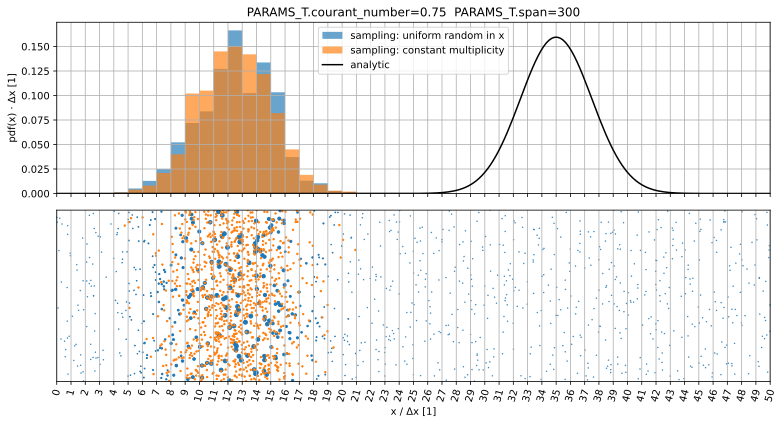

In [92]:
plot(
    particles=PARTICLES,
    params_x=PARAMS_X,
    params_p=PARAMS_P,
    rng=RNG,
    shift=PARAMS_T.wind * PARAMS_T.span,
    title=f'{PARAMS_T.courant_number=:.3g}  {PARAMS_T.span=}'
)